In [6]:
# 1. Import libraries
import ast 
import pandas as pd
from datasets import load_dataset 
import matplotlib.pyplot as plt
import seaborn as sns 

# 2. Load a dataset
ds = load_dataset("lukebarousse/data_jobs")  

df_copy = ds['train'].to_pandas()  

df = df_copy.copy()  


# 3. Data cleaning
df['job_posted_date'] = pd.to_datetime(df.job_posted_date)  

df['job_skills'] = df['job_skills'].apply(
    lambda skills: ast.literal_eval(skills) if pd.notna(skills) else []
)

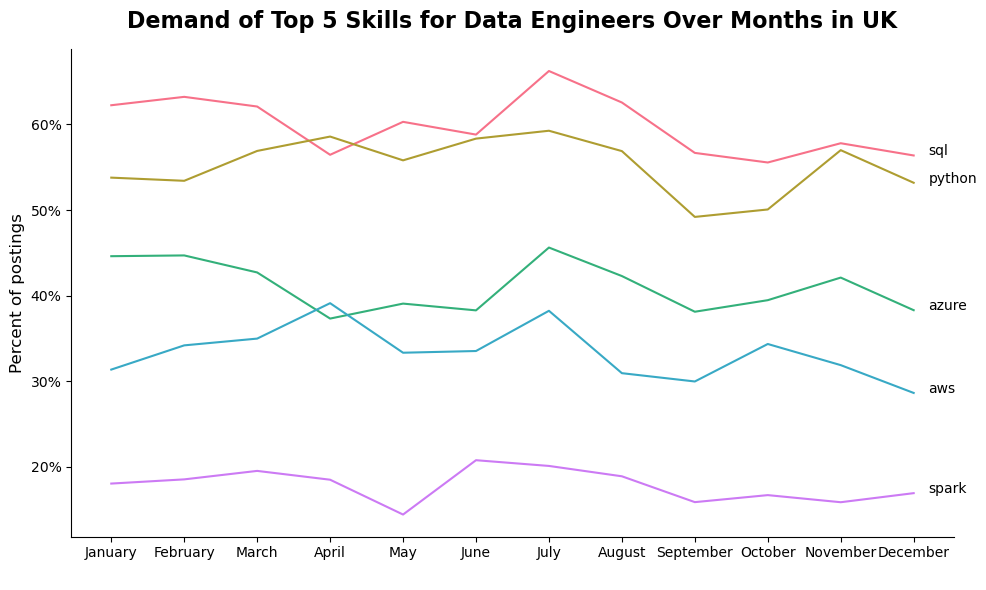

In [7]:
# 1. Filter dataset for a specific country and job title
df_uk = df[(df['job_country'] == df['job_country'].value_counts().index[2]) & (df['job_title_short'] == df['job_title_short'].value_counts().index[1])].copy()
# Select the third most common country and the second most common job title

# 2. Extract the month from job posting dates
df_uk['job_post_month'] = df_uk['job_posted_date'].dt.month  
# Creates a new column with the month number

# 3. Explode the job_skills list into separate rows
df_uk_exp = df_uk.explode(column='job_skills')

# 4. Create a pivot table to count skill occurrences per month
df_table = df_uk_exp.pivot_table(
    index='job_post_month', 
    columns='job_skills', 
    aggfunc='size'
)

# 5. Identify top 5 skills across all months
df_table.loc['total'] = df_table.sum()  # Add a row with total counts per skill
df_table = df_table.sort_values(by='total', axis=1, ascending=False).iloc[:, :5]  # Keep top 5
total = df_uk.groupby('job_post_month').size()  # Total postings per month
df_table.drop('total', inplace=True)  # Remove the temporary total row

# 6. Convert counts to percentages of total postings per month
df_pct = df_table.div(total / 100, axis=0).round(2)

# 7. Clean up the table for plotting
df_pct.reset_index(inplace=True)
df_pct['month'] = pd.to_datetime(df_pct['job_post_month'], format='%m').dt.month_name()  
df_pct.set_index('month', inplace=True)
df_pct.drop(columns='job_post_month', inplace=True)

# 8. Plot the monthly demand of top 5 skills
plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", 5)

sns.lineplot(df_pct, palette=colors, dashes=False)
sns.despine()  # Remove top and right spines for a cleaner look

# Add labels at the end of each line
for i in range(5):
    plt.text(11.2, df_pct.iloc[-1, i], df_pct.columns[i])

# Format y-axis as percentages
from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))

# Remove legend, add titles and labels
plt.legend().remove()
plt.ylabel('Percent of postings', fontsize=12)
plt.title(
    'Demand of Top 5 Skills for Data Engineers Over Months in UK', 
    fontsize=16, fontweight='bold', pad=15
)
plt.xlabel(' ')
plt.tight_layout()
plt.show()